<a href="https://colab.research.google.com/github/anomara1/DrAhmedOmara/blob/main/image_specific_distance_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

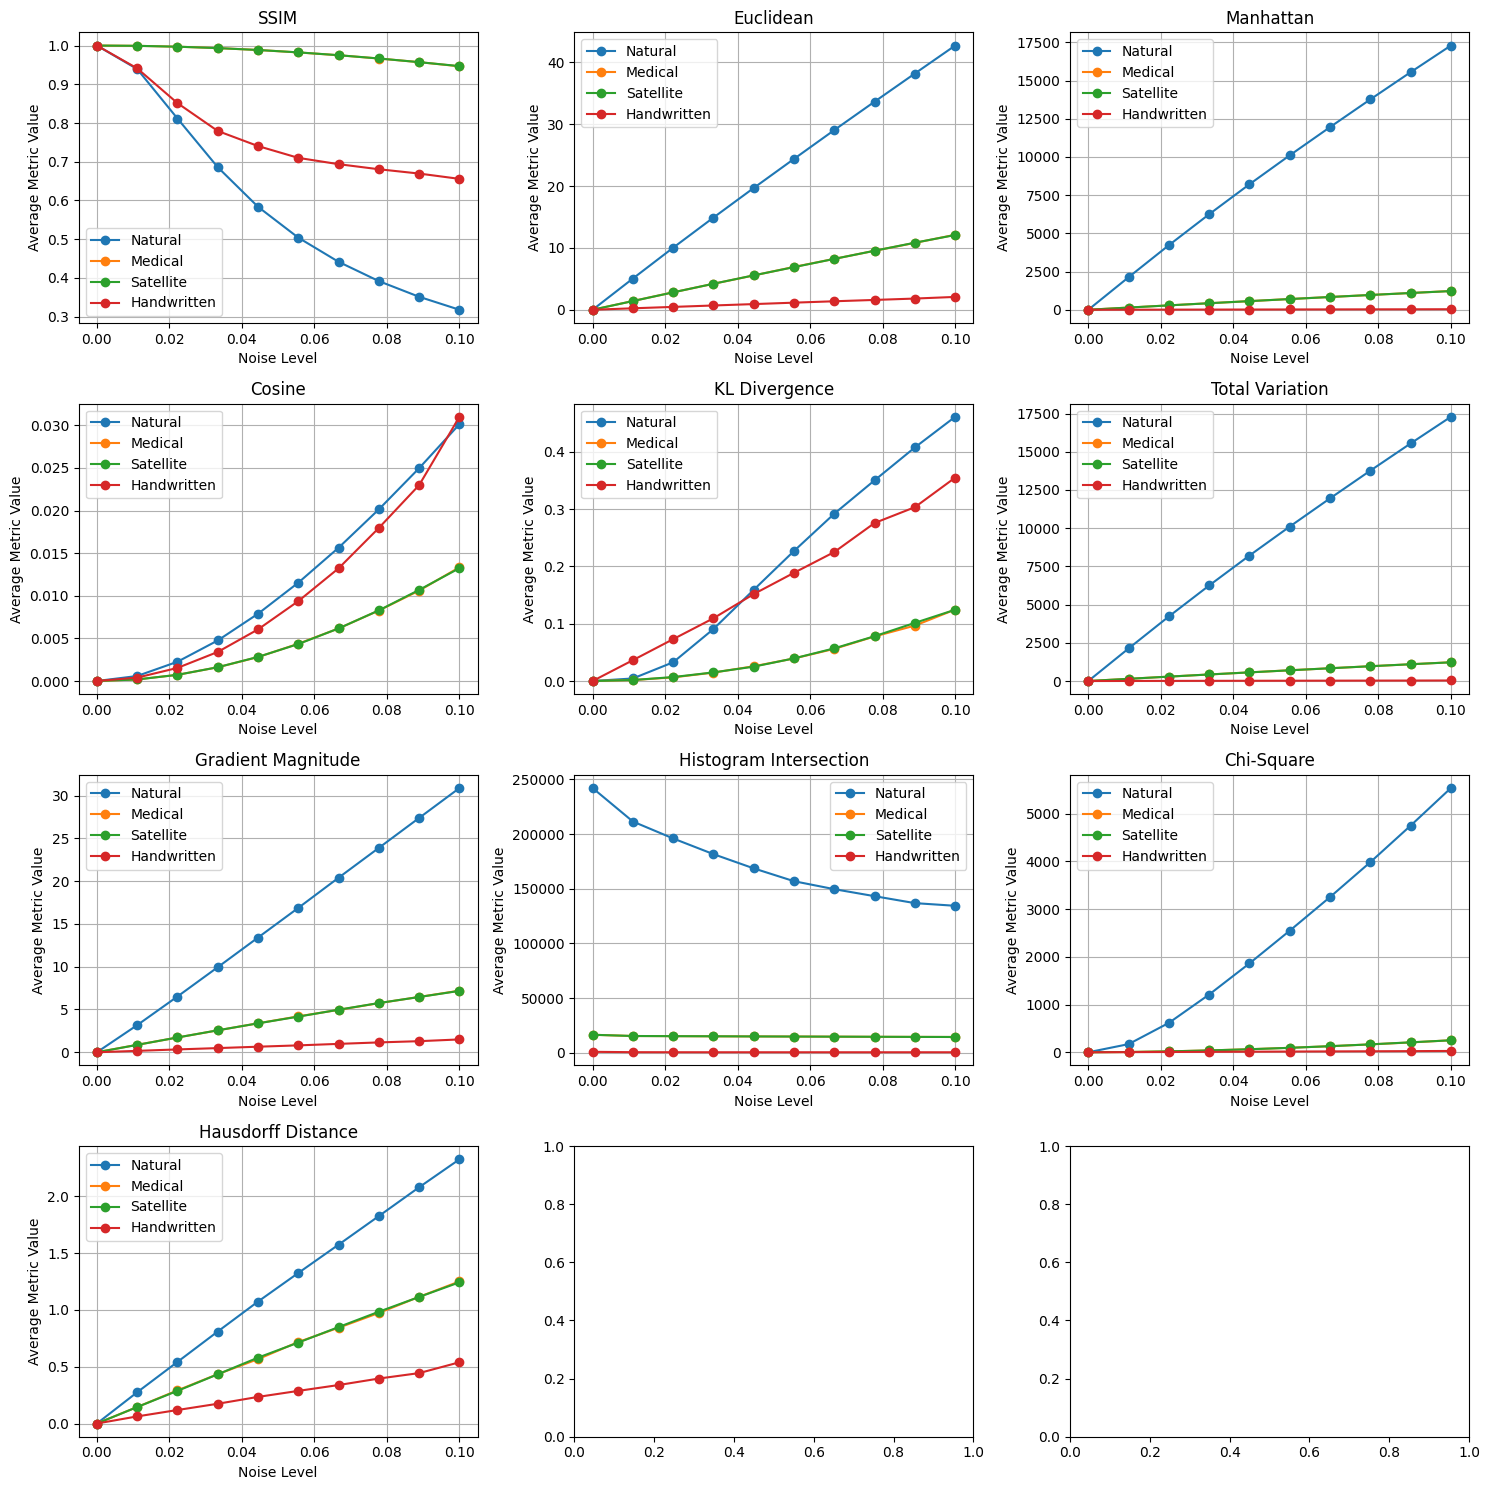

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import entropy
from skimage.color import rgb2gray
from scipy.linalg import norm
from skimage.filters import sobel
from scipy.spatial.distance import directed_hausdorff
from tensorflow.keras.datasets import mnist, cifar10

# Function to add noise
def add_noise(image, noise_level):
    return random_noise(image, var=noise_level**2)

# Function to compute distance metrics
def compute_metrics(original, noisy):
    metrics = {}
    metrics['SSIM'] = ssim(original, noisy, data_range=1)
    metrics['Euclidean'] = euclidean(original.ravel(), noisy.ravel())
    metrics['Manhattan'] = cityblock(original.ravel(), noisy.ravel())
    metrics['Cosine'] = cosine(original.ravel(), noisy.ravel())
    metrics['KL Divergence'] = entropy(original.ravel() + 1e-10, noisy.ravel() + 1e-10)
    metrics['Total Variation'] = np.sum(np.abs(original - noisy))
    metrics['Gradient Magnitude'] = norm(sobel(original) - sobel(noisy))
    metrics['Histogram Intersection'] = np.sum(np.minimum(np.histogram(original, bins=256)[0], np.histogram(noisy, bins=256)[0]))
    metrics['Chi-Square'] = np.sum((original.ravel() - noisy.ravel())**2 / (original.ravel() + noisy.ravel() + 1e-10))
    metrics['Hausdorff Distance'] = directed_hausdorff(original, noisy)[0]
    return metrics

# Load images from different categories
def preprocess_image(image):
    image = img_as_float(image)
    return rgb2gray(image) if image.ndim == 3 else image

categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.hubble_deep_field()),
                 preprocess_image(data.chelsea()), preprocess_image(data.clock()),
                 preprocess_image(data.page()), preprocess_image(data.coins()),
                 preprocess_image(data.brick()), preprocess_image(data.text())],
    "Medical": [np.random.rand(128, 128) for _ in range(10)],  # Placeholder for medical images
    "Satellite": [np.random.rand(128, 128) for _ in range(10)],  # Placeholder for satellite images
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Noise levels to test
noise_levels = np.linspace(0, 0.1, 10)

# Compute average metrics per category
results = {category: {key: np.zeros(len(noise_levels)) for key in ['SSIM', 'Euclidean', 'Manhattan', 'Cosine', 'KL Divergence', 'Total Variation', 'Gradient Magnitude', 'Histogram Intersection', 'Chi-Square', 'Hausdorff Distance']}
           for category in categories}

for category, images in categories.items():
    for image in images:
        for i, noise in enumerate(noise_levels):
            noisy_image = add_noise(image, noise)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Average results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot results
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Noise Level")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()
